# Naive bayesian decoder
Generative classifiers

Conditional probabilities

Tuning curves to probabilities

Bayes rule

Naive bayes classifier with numpy

Naive bayes classifier with sklearn

Noise correlation and normalization



In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from source.spikes import spikes_to_df, rf

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generative vs. discriminative classifiers

So far we have used logistic regression classifiers to do our decoding. These take a set of features and use them to predict the probability of the event class that generated it. 

## Conditional probability

We already mentioned conditional probabilities when discussing how to interpret the logistic function. In that case, the logisitic function reflects the probability of a certain event occurring given the features in our data, $p(y|x)$, where $y$ is the event and $x$ are the features. Across all possible classes there will be a different $p(y_k|x)$, and the sum of those probabilities across all possible classes will be 1:

$$ \sum_{k=1}^{K}{p(y_k|x)} = 1 $$

When evaluating the probability across all classes, the $x$ is kept constant. 

The general way to express conditional probability is:

$$ p(y|x) = \frac{p(y,x)}{p(x)} \tag{eq. 1} $$

Here $p(y,x)$ is the probability that particular instances of $y$ and $x$ ever co-occur. If we divide that by the probability of $x$ occurring, $p(x)$, then we have the probability of $y$ *conditional* on $x$. That is, it is the probability of $y$ for all instances when $x$ is of a particular value.

When $y$ and $x$ are conditionally independent of one another then $p(y|x)=p(y)p(x)$. This just means that the chance $y$ occurring with $x$ will equal to the probability that either of those happen in general (irrespective of each other). This is what is meant by conditional independence. 



## Bayes' theorem

Given equation 1 and a little algebra, we can establish a fundamental relationship between conditional probabilities known as Bayes' rule or theorem. Note that swapping $x$ and $y$, we get the equation $p(x|y)=\frac{p(x,y)}{p(y)}$. Also note that $p(y,x) = p(x,y)$. With these facts, we can write:

$$ \begin{align}
    p(y|x)p(x) &= p(y,x) = p(x,y) = p(x|y)p(y) \notag \\
    p(y|x)p(x) &= p(x|y)p(y) \notag \\
    p(y|x) &= \frac{p(x|y)p(y)}{p(x)} \tag{2} \\
    \end{align}
$$

This powerful relationship shows how to go from the conditional probability of $x$ given $y$, to that of $y$ given $x$. 

Why is this relaiontship important? Returning to decoders, their goal is to estimate the probability of behavioral or stimulus events, $y_k$, given patterns in brain activity, $x$. In the previous lectures we estimated this probability, $p(y_k|x)$ using logistic regression. The event $k$ with the largest probability was then chosen as the one most likely to have occured. However, Bayes' theorem offers an alternative approach. Instead we can derive that by measuring the probability of observing our brain data given that event $y_k$ occured and use that, along with our knowledge about how often $y_k$ occurs.

Bayes' theorem is so prominent that each term in it has a name:
1. $p(y|x)$ is the *posterior*. This is the probability of an event given the brain data.
2. $p(x|y)$ is the *likelihood*. This is the probability of the brain data given an event.
3. $p(y)$ is the *prior*. This is the probability of an event occuring.
4. $p(x)$ is the *evidence*. This is the probability of the observed brain data occuring.

Both the likelihood and prior can be determined from the data we have been working with so far. Less tractable is an estimate of the evidence, the probability of the brain data, because that would require us to observe all possible brain states. Fortunately, with classification we just want the event with the highest probability, and do not care about its *actual* probability. For a given decoding estimate we, we want to estimate $p(y|x)$ for a certain brain state we observed, $x$. This means that the $p(x)$ in Bayes' rule will be held constant across all possible events, $y_k$. Thus, while we do not know the exact value of $p(x)$, it is just rescaling the values of $p(y|x)$. This will not change which $y_k$ is highest or lowest, so leaving it out has no impact on our ability to classify. As a result, for our decoder can use the following rule:

$$ \text{selection} = \arg\max_{y_k}p(x|y)p(y) $$

Let's give this a try with a single neuron from the Allen Institute data set.

## Bayes' theorem and the single neuron

To start, we will load in the neurons from last week and select one with well defined tuning for orientation.

In [3]:
# initialize data cache
allen_dir = ['..','data','spike_allen']
manifest_path = os.path.join(*allen_dir,'manifest.json')
cache = EcephysProjectCache(manifest=manifest_path)

# get session
sess_id = 750332458
sess = cache.get_session_data(sess_id, filter_by_validity=False)
stims = sess.stimulus_presentations

# get the ids of the units that passed quality control last week
# save as an numpy file where the Allen cache is stored
ids_path = os.path.join(*allen_dir,'clean_unit_ids.npy')
unit_ids = np.load(ids_path)

# get stimulus presentations
dg_stims = stims[stims['stimulus_name'] == 'drifting_gratings']
dg_stims = dg_stims[(dg_stims['contrast']!='null') |
                    (dg_stims['spatial_frequency']!='null') |
                    (dg_stims['orientation']!='null') |
                    (dg_stims['temporal_frequency']!='null')]

# get the spike times as a dataframe
spikes = spikes_to_df(sess)

# keep only those rows whose index is in unit_ids
spikes = spikes[spikes.index.isin(unit_ids)]

# compute orientation RF for each unit
spikes['rf_ori'] = spikes['times'].apply(
    lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['orientation']))

# get the empirical orientation tuning curve
spikes['rf_ori_emp'] = spikes['rf_ori'].apply(lambda x: x.rf())

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [63]:
sel_unit = 951815599
rf_ori_counts = spikes.loc[sel_unit,'rf_ori'].stim_counts
rf_ori_mean = spikes.loc[sel_unit,'rf_ori_emp']

Text(0.5, 1.0, 'Orientation tuning curve for unit 951815599')

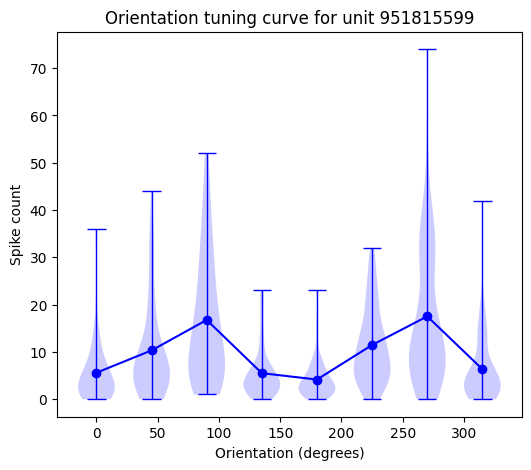

In [75]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rf_ori_mean[2][0], rf_ori_mean[0].flatten(), 'o-', color='blue')


for ori, counts in rf_ori_counts.iterrows():
    vp = ax.violinplot(counts.values[0], positions=[ori], widths=30)
    vp['bodies'][0].set_facecolor('blue')
    vp['bodies'][0].set_alpha(0.2)
    for line in ['cmaxes', 'cmins', 'cbars']:
        vp[line].set_edgecolor('blue')
        vp[line].set_linewidth(1)
ax.set_xlabel('Orientation (degrees)')
ax.set_ylabel('Spike count')
ax.set_title('Orientation tuning curve for unit {}'.format(sel_unit))

An alternative way to visualize this is the probability of observing some spike count, $x$, and and orientation, $y$. This is expressed as $p(x,y)$.

We can do this by counting the number of times each number of spike counts occured for each orientation and placing that into an array. The rows will be the spike counts and the columns the orientations.

In [89]:
rf_ori_counts = rf_ori_counts.loc[[315, 0, 90, 45, 180, 270, 135, 225],:]
rf_ori_counts

,spike_counts
orientation,
315.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 4.0, 7.0, 1.0, ..."
0.0,"[0.0, 3.0, 1.0, 1.0, 4.0, 1.0, 2.0, 6.0, 13.0,..."
90.0,"[11.0, 3.0, 6.0, 5.0, 21.0, 28.0, 20.0, 1.0, 1..."
45.0,"[8.0, 15.0, 10.0, 0.0, 0.0, 9.0, 0.0, 2.0, 2.0..."
180.0,"[0.0, 1.0, 4.0, 1.0, 4.0, 1.0, 1.0, 3.0, 8.0, ..."
270.0,"[12.0, 8.0, 8.0, 9.0, 12.0, 14.0, 2.0, 12.0, 1..."
135.0,"[1.0, 3.0, 1.0, 1.0, 0.0, 7.0, 1.0, 3.0, 8.0, ..."
225.0,"[6.0, 0.0, 1.0, 8.0, 14.0, 3.0, 13.0, 13.0, 9...."


In [93]:
rf_ori_counts.sort_index(inplace=True)

In [101]:
num_stim = rf_ori_counts.shape[0]
max_counts = int(rf_ori_counts['spike_counts'].apply(lambda x: x.max()).max())

joint_dist = np.zeros((max_counts+1, num_stim))
for i, (_, counts) in enumerate(rf_ori_counts.iterrows()):
    joint_dist[:,i] = np.histogram(counts.values[0], bins=np.arange(max_counts+2))[0]

joint_dist = joint_dist / joint_dist.sum()

Text(0.5, 1.0, 'Joint probability distribution of spike counts and orientation')

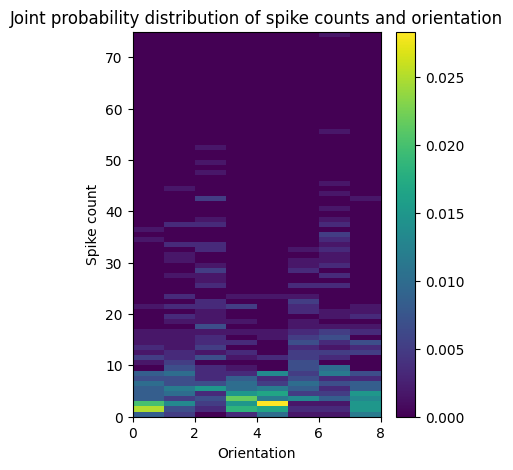

In [110]:
fig, ax = plt.subplots(figsize=(4,5))
ax.pcolormesh(joint_dist)
fig.colorbar(ax=ax, mappable=ax.collections[0])
ax.set_xlabel('Orientation')
ax.set_ylabel('Spike count')
ax.set_title('Joint probability distribution of spike counts and orientation')

When calculating the joint probability, we are tallying the number of times we observed a certain count for each orientation condition, and then dividing by the total number of joint events tallied. 

Notice that the probabitliies are not smooth but spotty and sometimes have gaps between them. 